# Link to GitHub Repo: [Click Here](https://github.com/mohitrathod7/Bike-Share-Toronto/tree/main/Modeling)   



# About Dataset

Ridership Data source: https://open.toronto.ca/dataset/bike-share-toronto-ridership-data/

Station Location Data source: https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information

# Setup and reading data

In [ ]:
# !pip install haversine
# !pip install folium

In [ ]:
from datetime import datetime
from haversine import haversine, Unit
import glob, os, math, requests, random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors

import seaborn as sns
import folium
from folium.plugins import MarkerCluster

%matplotlib inline

pd.set_option('display.max_columns', None)

Using Google Colab

In [ ]:
import glob

# Get a list of all CSV files starting with "2018"
csv_files = glob.glob("/content/drive/MyDrive/Colab Notebooks/Toronto Bikeshare/2018*.csv")

# Create an empty list to store DataFrames
dataframes = []

# Iterate through the CSV files and read them into DataFrames
for csv_file in csv_files:
    # Read each CSV file and append the DataFrame to the list
    df = pd.read_csv(csv_file)
    dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame
trips_df = pd.concat(dataframes, ignore_index=True)

trips_df.head()

Using Local System

In [ ]:
# # Specify the path and pattern for the CSV files
# # This will look for all CSV files in the specified directory
# csv_files = glob.glob('datasets/2018/*.csv')

# # Create a list to hold the DataFrames
# dataframes = []

# # Loop through the list of file paths
# for file in csv_files:
#     # Read each CSV file and append the DataFrame to the list
#     df = pd.read_csv(file)
#     dataframes.append(df)

# # Concatenate all DataFrames into a single DataFrame
# trips_df = pd.concat(dataframes, ignore_index=True)

# trips_df.head(5)

# Adding locations to `trips_df` dataframe

In [ ]:
# URL of the JSON data
url = 'https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information'

# Fetch the JSON data
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Load JSON data
    data = response.json()

    # Convert JSON to DataFrame
    bike_stations_df = pd.json_normalize(data['data']['stations'])
    print("Data successfully fetched")
else:
    print(f"Failed to fetch data: {response.status_code}")

Data successfully fetched


In [ ]:
bike_stations_df.head(2)

,station_id,name,physical_configuration,lat,lon,altitude,address,capacity,is_charging_station,rental_methods,groups,obcn,short_name,nearby_distance,_ride_code_support,post_code,is_valet_station,cross_street
0,7000,Fort York Blvd / Capreol Ct,REGULAR,43.639832,-79.395954,NaN,Fort York Blvd / Capreol Ct,47,False,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[South],647-643-9607,647-643-9607,500.0,True,NaN,NaN,NaN
1,7001,Wellesley Station Green P,ELECTRICBIKESTATION,43.664964,-79.383550,NaN,Yonge / Wellesley,23,True,"[KEY, TRANSITCARD, CREDITCARD, PHONE]","[E-Charging , South]",416-617-9576,416-617-9576,500.0,True,M4Y 1G7,NaN,NaN


In [ ]:
bike_stations_df.shape

(851, 18)

Converting ID column to Integer

In [ ]:
bike_stations_df['station_id'] = bike_stations_df['station_id'].astype(int)

In [ ]:
# Delete the specified columns
columns_to_drop = ['physical_configuration', 'altitude', 'address','capacity', 'is_charging_station', 'rental_methods', 'groups', 'obcn', 'short_name', 'nearby_distance', '_ride_code_support', 'post_code', 'is_valet_station', 'cross_street']
bike_stations_df.drop(columns=columns_to_drop, inplace=True)
bike_stations_df.head(3)

,station_id,name,lat,lon
0,7000,Fort York Blvd / Capreol Ct,43.639832,-79.395954
1,7001,Wellesley Station Green P,43.664964,-79.383550
2,7002,St. George St / Bloor St W,43.667131,-79.399555


In [ ]:
# Delete "IDs" in bike_stations_df that are not in trips_df
bike_stations_df = bike_stations_df[bike_stations_df['station_id'].isin(trips_df['from_station_id'])].reset_index(drop=True)

# Display the filtered DataFrame
bike_stations_df.head(5)
print(bike_stations_df.shape)

(330, 4)


Renaming bike stations to thier old names in 2018

In [ ]:
# Create a mapping of station ID to station name from trips_df
name_mapping = trips_df[['from_station_id', 'from_station_name']].drop_duplicates().set_index('from_station_id')['from_station_name'].to_dict()

# Update the station names in bike_stations_df based on the mapping
bike_stations_df['name'] = bike_stations_df['station_id'].map(name_mapping).combine_first(bike_stations_df['name'])

In [ ]:
bike_stations_df.head(3)

,station_id,name,lat,lon
0,7000,Fort York Blvd / Capreol Ct,43.639832,-79.395954
1,7001,Lower Jarvis St / The Esplanade,43.664964,-79.383550
2,7002,St. George St / Bloor St W,43.667131,-79.399555


List of coordinates of stations missing data, I mannualy found it

In [ ]:
missing_coordinates = {
    # ID: [Name, LAT, LON]
    7060: ['Princess St / Adelaide St E',                   43.652364279365386, -79.38072119893286],
    7177: ['East Liberty St / Pirandello St',               43.639083,          -79.414222],
    7062: ['University Ave / College St (West)',            43.659944,          -79.406389],
    7251: ['The Royal Ontario Museum (Bloor St Entrance)',  43.668444,          -79.405028],
    7011: ['Portland St & Wellington St W',                 43.642917,          -79.405472],
    7051: ['Wellesley St E / Yonge St (Green P)',           43.6655,            -79.395278],
    7275: ['Queen St W / James St',                         43.652364279365386, -79.38072119893286],
    7067: ['Yonge St / Harbour St',                         43.64256307021582,  -79.37620018149019],
    7004: ['University Ave / Elm St',                       43.656365196668915, -79.38781487252689],
    7255: ['Stewart St / Bathurst St  - SMART',             43.64318006677627,  -79.40220532120897],
    7056: ['Parliament St / Gerrard St',                    43.66190892497103,  -79.36689083621276],
    7263: ['Walton St / Elizabeth St - SMART',              43.65775951515591,  -79.38605778701378],
    7167: ['Queen St E / George St (Moss Park)',            43.65391112056363,  -79.37194228233268],
    7058: ['Huron / Harbord St',                            43.663701672289875, -79.40005460166932],
    7099: ['Cherry St / Mill St',                           43.65131162754315,  -79.35721626639824],
    7072: ['Queen St W / Shaw St',                          43.64466219786213,  -79.41611373593442],
    7254: ['Borden St / Bloor St W - SMART',                43.66572398943307,  -79.40878207642875],
    7293: ['College St / McCaul St',                        43.65911010024858,  -79.39345145632274],
    7136: ['Queen St W / Close Ave',                        43.64070304242879,  -79.4359587134529],
    7179: ['Bloor GO / UP Station (West Toronto Railpath)', 43.656427257520185, -79.45167849957652],
    7382: ['Simcoe St / Adelaide St W',                     43.64860574452701,  -79.3864666429806],
    7372: ['King St W / Portland St',                       43.644389289112645, -79.40065141953072],
    7134: ['Marlborough Ave / Yonge St',                    43.67994219829935,  -79.38995166624743],
    7249: ['Dovercourt Rd / Harrison St (Green P) - SMART', 43.65047864724172,  -79.42425799717319],
    7092: ['Pape Subway Green P',                           43.68021607325339,  -79.34413045292051],
    7328: ['Roxborough St W / Yonge St',                    43.67807392458066,  -79.390372189717],
    7330: ['Lee Ave / Queen St E',                          43.6699549059716,   -79.29785451573214],
    7369: ['Dupont St / Emerson Ave - SMART',               43.6671597202503,   -79.44423150877314],
    7219: ['Wolfpack - 7219',                               43.639445987085494, -79.42360693630165]
}

In [ ]:
# Dictionary containing the correct coordinates
correct_coordinates = {
    7322: ["King St W / Brant St", 43.645102433201394, -79.39742774871179],
}

# Iterate over the correct_coordinates dictionary to update bike_stations_df
for station_id, coords in correct_coordinates.items():
    bike_stations_df.loc[bike_stations_df['station_id'] == station_id, ['name', 'lat', 'lon']] = coords

In [ ]:
# Create a DataFrame from the stations_coordinates
missing_stations_df = pd.DataFrame.from_dict(missing_coordinates, orient='index', columns=['name', 'lat', 'lon']).reset_index()
missing_stations_df.rename(columns={'index': 'station_id'}, inplace=True)

# Merge the DataFrames
bike_stations_df = pd.concat([bike_stations_df, missing_stations_df], ignore_index=True)

bike_stations_df.head(3)

,station_id,name,lat,lon
0,7000,Fort York Blvd / Capreol Ct,43.639832,-79.395954
1,7001,Lower Jarvis St / The Esplanade,43.664964,-79.383550
2,7002,St. George St / Bloor St W,43.667131,-79.399555


In [ ]:
bike_stations_df.shape

(359, 4)

Merge bike station locations to trips data

In [ ]:
# Merge lat/lon of start stations
trips_df = trips_df.merge(bike_stations_df[['station_id', 'lat', 'lon']],
                           left_on='from_station_id', right_on='station_id', how='left')

# Rename the lat/lon columns after merging for clarity
trips_df.rename(columns={'lat': 'from_lat', 'lon': 'from_lon'}, inplace=True)

# Merge lat/lon of end stations
trips_df = trips_df.merge(bike_stations_df[['station_id', 'lat', 'lon']],
                           left_on='to_station_id', right_on='station_id', how='left')

# Rename the lat/lon columns for end stations
trips_df.rename(columns={'lat': 'to_lat', 'lon': 'to_lon'}, inplace=True)

trips_df.drop(["station_id_x", "station_id_y"], axis=1, inplace=True)

# Select only the first occurrence of each column name if we got any
trips_df = trips_df.loc[:, ~trips_df.columns.duplicated()]

In [ ]:
trips_df.head(3)

,trip_id,trip_duration_seconds,from_station_id,trip_start_time,from_station_name,trip_stop_time,to_station_id,to_station_name,user_type,from_lat,from_lon,to_lat,to_lon
0,2383648,393,7018,1/1/2018 0:47,Bremner Blvd / Rees St,1/1/2018 0:54,7176,Bathurst St / Fort York Blvd,Annual Member,43.641529,-79.386741,43.639179,-79.399595
1,2383649,625,7184,1/1/2018 0:52,Ossington Ave / College St,1/1/2018 1:03,7191,Central Tech (Harbord St),Annual Member,43.654491,-79.422634,43.661975,-79.407896
2,2383650,233,7235,1/1/2018 0:55,Bay St / College St (West Side) - SMART,1/1/2018 0:59,7021,Bay St / Albert St,Annual Member,43.660087,-79.385655,43.653264,-79.382458


# Exploratory Data Analysis

In [ ]:
trips_df.size

24998415

In [ ]:
trips_df.shape

(1922955, 13)

In [ ]:
trips_df.dtypes

,0
trip_id,int64
trip_duration_seconds,int64
from_station_id,int64
trip_start_time,object
from_station_name,object
trip_stop_time,object
to_station_id,int64
to_station_name,object
user_type,object
from_lat,float64


In [ ]:
trips_df.nunique()

,0
trip_id,1922955
trip_duration_seconds,17609
from_station_id,359
trip_start_time,366574
from_station_name,359
trip_stop_time,366328
to_station_id,359
to_station_name,359
user_type,2
from_lat,356


In [ ]:
# Check all null values, and deal with it if any exists
trips_df.isnull().sum()

,0
trip_id,0
trip_duration_seconds,0
from_station_id,0
trip_start_time,0
from_station_name,0
trip_stop_time,0
to_station_id,0
to_station_name,0
user_type,0
from_lat,0


In [ ]:
trips_df.describe()

,trip_id,trip_duration_seconds,from_station_id,to_station_id,from_lat,from_lon,to_lat,to_lon
count,1.922955e+06,1.922955e+06,1.922955e+06,1.922955e+06,1.922955e+06,1.922955e+06,1.922955e+06,1.922955e+06
mean,3.490799e+06,9.629760e+02,7.134140e+03,7.133976e+03,4.365411e+01,-7.939111e+01,4.365338e+01,-7.939061e+01
std,6.248957e+05,1.595530e+03,1.034228e+02,1.035460e+02,1.184683e-02,2.572973e-02,1.160537e-02,2.609727e-02
min,2.383648e+06,6.000000e+01,7.000000e+03,7.000000e+03,4.362244e+01,-7.948028e+01,4.362244e+01,-7.948028e+01
25%,2.955252e+06,4.220000e+02,7.042000e+03,7.042000e+03,4.364561e+01,-7.940320e+01,4.364534e+01,-7.940280e+01
50%,3.494072e+06,6.700000e+02,7.109000e+03,7.107000e+03,4.365282e+01,-7.938783e+01,4.365236e+01,-7.938778e+01
75%,4.027558e+06,1.051000e+03,7.222000e+03,7.222000e+03,4.366271e+01,-7.937990e+01,4.366167e+01,-7.937988e+01
max,4.581277e+06,5.507700e+04,7.391000e+03,7.391000e+03,4.371122e+01,-7.927968e+01,4.371122e+01,-7.927968e+01


# Feature Engineering

## Convert to Datetime format

In [ ]:
def convert_dates(df, start_column, end_column):
    # Define the formats you want to support for input parsing
    date_formats = [
        "%d/%m/%Y %H:%M", "%m/%d/%Y %H:%M",
        "%d/%m/%Y %I:%M %p", "%m/%d/%Y %I:%M %p", "%Y-%m-%d %I:%M:%S %p",
        "%Y-%m-%d %H:%M:%S", "%d/%m/%Y %H:%M:%S",
        "%m/%d/%Y %H:%M", "%m/%d/%y %H:%M", "%m/%d/%y %H:%M:%S"
    ]

    # Function to parse dates with specified formats
    def parse_dates(date_series):
        for fmt in date_formats:
            # Attempt to parse dates with the current format
            parsed_dates = pd.to_datetime(date_series, format=fmt, errors='coerce')
            # If parsing results in non-null values, return them
            if parsed_dates.notnull().all():
                return parsed_dates

        # If none of the formats work, return NaT for unparseable dates
        return pd.to_datetime(date_series, errors='coerce')

    # Convert start and end times using the parsing function
    start_dates = parse_dates(df[start_column])
    end_dates   = parse_dates(df[end_column])

    # Log unparseable dates
    if start_dates.isnull().any():
        unparseable_starts = df[start_column][start_dates.isnull()]
        print(f"Could not parse start dates: {unparseable_starts.tolist()}")

    if end_dates.isnull().any():
        unparseable_ends = df[end_column][end_dates.isnull()]
        print(f"Could not parse end dates: {unparseable_ends.tolist()}")

    # Convert parsed dates to the desired standard format: %d/%m/%Y %H:%M:%S
    start_dates = start_dates.dt.strftime("%d/%m/%Y %H:%M:%S")
    end_dates   = end_dates.dt.strftime("%d/%m/%Y %H:%M:%S")

    return start_dates, end_dates

# Process the merged trips DataFrame
trips_df['trip_start_time'], trips_df['trip_stop_time'] = convert_dates(trips_df, 'trip_start_time', 'trip_stop_time')

# Convert back to datetime type after formatting, if necessary for further analysis
trips_df['trip_start_time'] = pd.to_datetime(trips_df['trip_start_time'], format="%d/%m/%Y %H:%M:%S", errors='coerce')
trips_df['trip_stop_time']  = pd.to_datetime(trips_df['trip_stop_time'],  format="%d/%m/%Y %H:%M:%S", errors='coerce')

# Display the updated DataFrame
trips_df.head()

Extract minute, hour, day of the week, and month for `trip_start_time`

In [ ]:
trips_df['trip_start_hour']        = trips_df['trip_start_time'].dt.hour
trips_df['trip_start_minute']      = trips_df['trip_start_time'].dt.minute
trips_df['trip_start_day_of_week'] = trips_df['trip_start_time'].dt.day_name()    # Day of the week as a string (e.g., Monday)
trips_df['trip_start_month']       = trips_df['trip_start_time'].dt.month_name()  # Month as a string (e.g., January)

Make Days and Month Categorical variable and set thier order

In [ ]:
# Sort days of the week for proper order
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
trips_df['trip_start_day_of_week'] = pd.Categorical(trips_df['trip_start_day_of_week'], categories=days_order, ordered=True)
trips_df = trips_df.sort_values('trip_start_day_of_week')

# Sort months for proper order
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
trips_df['trip_start_month'] = pd.Categorical(trips_df['trip_start_month'], categories=months_order, ordered=True)
trips_df = trips_df.sort_values('trip_start_month')

We will retain all ID columns as integers because integers are more space-efficient than strings, especially when managing millions of records. This approach will help optimize our storage and enhance overall performance.

In [ ]:
trips_df['from_station_name'] = trips_df['from_station_name'].astype(str)
trips_df['to_station_name']   = trips_df['to_station_name'].astype(str)
trips_df['user_type']         = trips_df['user_type'].astype(str)

In [ ]:
trips_df['is_weekend'] = trips_df['trip_start_day_of_week'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

In [ ]:
# Convert trips duration seconds to minutes
trips_df['trip_duration_minutes'] = (trips_df['trip_duration_seconds']/60).round(2)

In [ ]:
def categorize_time(hour):
    if 7 <= hour <= 10:
        return 'morning'
    elif 17 <= hour <= 20:
        return 'evening'
    else:
        return 'off_peak'

trips_df['rush_hour_category'] = trips_df['trip_start_hour'].apply(categorize_time)

In [ ]:
trips_df.head()

## Mapping

In [ ]:
# Mapping for `user_type`
user_type_map = {
    'Annual Member': 1, 'Casual Member': 0
}

# Mapping for Cyclic encoding for `day_of_week` (7-day cycle)
day_of_week_map = {
    "Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, "Friday": 4, "Saturday": 5, "Sunday": 6
}

# Mapping for Cyclic encoding for `month` (12-month cycle)
month_map = {
    "January": 1, "February": 2, "March": 3, "April": 4,
    "May": 5, "June": 6, "July": 7, "August": 8,
    "September": 9, "October": 10, "November": 11, "December": 12
}

In [ ]:
trips_df.head()

## Changing column names

In [ ]:
trips_df.columns

Index(['trip_id', 'trip_duration_seconds', 'from_station_id',
       'trip_start_time', 'from_station_name', 'trip_stop_time',
       'to_station_id', 'to_station_name', 'user_type', 'from_lat', 'from_lon',
       'to_lat', 'to_lon', 'trip_start_hour', 'trip_start_minute',
       'trip_start_day_of_week', 'trip_start_month', 'is_weekend',
       'trip_duration_minutes', 'rush_hour_category'],
      dtype='object')

In [ ]:
trips_df.rename(columns={
    'trip_id': 'id',
    'trip_duration_seconds': 'duration_seconds',
    'trip_duration_minutes': 'duration_minutes',

    'from_station_id': 'start_station_id',
    'to_station_id':   'end_station_id',

    'from_station_name': 'start_station_name',
    'to_station_name':   'end_station_name',

    'trip_start_time':        'start_time',
    'trip_start_hour':        'start_hour',
    'trip_start_minute':      'start_minute',
    'trip_start_day_of_week': 'start_day_of_week',
    'trip_start_month':       'start_month',
    'trip_stop_time':         'end_time',

    'user_type':               'user_type',

    'from_lat': 'start_lat',
    'from_lon': 'start_lon',
    'to_lat':   'end_lat',
    'to_lon':   'end_lon',

    'is_weekend': 'is_weekend',

    'rush_hour_category': 'rush_hour_category',
    'rush_hour_evening':  'rush_hour_evening',
    'rush_hour_morning':  'rush_hour_morning',
    'rush_hour_off_peak': 'rush_hour_off_peak'
}, inplace=True)


In [ ]:
trips_df.head()

,id,duration_seconds,start_station_id,start_time,start_station_name,end_time,end_station_id,end_station_name,user_type,start_lat,start_lon,end_lat,end_lon,start_hour,start_minute,start_day_of_week,start_month,is_weekend,duration_minutes,rush_hour_category
0,2383648,393,7018,2018-01-01 00:47:00,Bremner Blvd / Rees St,2018-01-01 00:54:00,7176,Bathurst St / Fort York Blvd,Annual Member,43.641529,-79.386741,43.639179,-79.399595,0,47,Monday,January,0,6.55,off_peak
9844,2396284,146,7114,2018-01-10 19:30:00,Carlton St / Parliament St,2018-01-10 19:32:00,7014,Sherbourne St / Carlton St (Allan Gardens),Annual Member,43.664524,-79.367930,43.663102,-79.373181,19,30,Wednesday,January,0,2.43,evening
9831,2396272,800,7034,2018-01-10 19:20:00,Church St / Bloor St E,2018-01-10 19:34:00,7095,Danforth Ave / Ellerbeck St,Annual Member,43.671389,-79.382919,43.677076,-79.356670,19,20,Wednesday,January,0,13.33,evening
9832,2396273,723,7179,2018-01-10 19:21:00,Bloor GO / UP Station (West Toronto Railpath),2018-01-10 19:33:00,7193,Queen St W / Gladstone Ave,Annual Member,43.656427,-79.451678,43.643097,-79.428756,19,21,Wednesday,January,0,12.05,evening
9833,2396274,622,7126,2018-01-10 19:23:00,Yonge St / Yorkville Ave,2018-01-10 19:33:00,7012,Elizabeth St / Edward St (Bus Terminal),Annual Member,43.671944,-79.387778,43.656026,-79.385327,19,23,Wednesday,January,0,10.37,evening


## Binary Encoding (Nominal Categorical Var), Hot and Cyclic Encoding (Ordinal Categorical Var)

### Binary Encoding

In [ ]:
# Hot encoding values "user_type"
user_type_dummies = pd.get_dummies(trips_df['user_type'], prefix='user_type')
trips_df = pd.concat([trips_df, user_type_dummies], axis=1)

# Binary mapping values in user_type column
trips_df['user_type'] = trips_df['user_type'].map(user_type_map) # doing it after because ehile doing hot-encoding we need user_type values in column not 0 or 1

# Hot encoding values "rush_hour"
rush_hour_dummies = pd.get_dummies(trips_df['rush_hour_category'], prefix='rush_hour')
trips_df = pd.concat([trips_df, rush_hour_dummies], axis=1)

trips_df.rename(columns={
    'user_type_Annual Member': 'user_type_annual_member',
    'user_type_Casual Member': 'user_type_casual_member'}, inplace=True
)

In [ ]:
trips_df.head()

,id,duration_seconds,start_station_id,start_time,start_station_name,end_time,end_station_id,end_station_name,user_type,start_lat,start_lon,end_lat,end_lon,start_hour,start_minute,start_day_of_week,start_month,is_weekend,duration_minutes,rush_hour_category,user_type_annual_member,user_type_casual_member,rush_hour_evening,rush_hour_morning,rush_hour_off_peak
0,2383648,393,7018,2018-01-01 00:47:00,Bremner Blvd / Rees St,2018-01-01 00:54:00,7176,Bathurst St / Fort York Blvd,1,43.641529,-79.386741,43.639179,-79.399595,0,47,Monday,January,0,6.55,off_peak,True,False,False,False,True
9844,2396284,146,7114,2018-01-10 19:30:00,Carlton St / Parliament St,2018-01-10 19:32:00,7014,Sherbourne St / Carlton St (Allan Gardens),1,43.664524,-79.367930,43.663102,-79.373181,19,30,Wednesday,January,0,2.43,evening,True,False,True,False,False
9831,2396272,800,7034,2018-01-10 19:20:00,Church St / Bloor St E,2018-01-10 19:34:00,7095,Danforth Ave / Ellerbeck St,1,43.671389,-79.382919,43.677076,-79.356670,19,20,Wednesday,January,0,13.33,evening,True,False,True,False,False
9832,2396273,723,7179,2018-01-10 19:21:00,Bloor GO / UP Station (West Toronto Railpath),2018-01-10 19:33:00,7193,Queen St W / Gladstone Ave,1,43.656427,-79.451678,43.643097,-79.428756,19,21,Wednesday,January,0,12.05,evening,True,False,True,False,False
9833,2396274,622,7126,2018-01-10 19:23:00,Yonge St / Yorkville Ave,2018-01-10 19:33:00,7012,Elizabeth St / Edward St (Bus Terminal),1,43.671944,-79.387778,43.656026,-79.385327,19,23,Wednesday,January,0,10.37,evening,True,False,True,False,False


### Cyclic Encoding

In [ ]:
# Cyclic encoding for 'hour' (since it ranges from 0 to 23) to capture the circular nature of time
trips_df['start_hour_sin'] = np.sin(2 * np.pi * trips_df['start_hour'] / 24)
trips_df['start_hour_cos'] = np.cos(2 * np.pi * trips_df['start_hour'] / 24)


# Ensure 'day_of_week' is treated as a standard object type
trips_df['start_day_of_week']     = trips_df['start_day_of_week'].astype(str)
trips_df['start_day_of_week_num'] = trips_df['start_day_of_week'].map(day_of_week_map)

# Apply sine and cosine transformations
trips_df['start_day_of_week_sin'] = np.sin(2 * np.pi * trips_df['start_day_of_week_num'] / 7)
trips_df['start_day_of_week_cos'] = np.cos(2 * np.pi * trips_df['start_day_of_week_num'] / 7)


# Ensure 'month' is treated as a standard object type
trips_df['start_month']     = trips_df['start_month'].astype(str)
trips_df['start_month_num'] = trips_df['start_month'].map(month_map)

# Apply sine and cosine transformations
trips_df['start_month_sin'] = np.sin(2 * np.pi * trips_df['start_month_num'] / 12)
trips_df['start_month_cos'] = np.cos(2 * np.pi * trips_df['start_month_num'] / 12)


### Renaming columns

In [ ]:
obj_columns = trips_df.select_dtypes(include=['object']).columns.tolist()
obj_columns

['start_station_name',
 'end_station_name',
 'start_day_of_week',
 'start_month',
 'rush_hour_category']

In [ ]:
# Drop all str type columns except for name ones
# columns_to_drop = ['start_day_of_week', 'start_month', 'rush_hour_category']
columns_to_drop = obj_columns[2:5]
trips_df = trips_df.drop(columns=columns_to_drop)
trips_df.head()


,id,duration_seconds,start_station_id,start_time,start_station_name,end_time,end_station_id,end_station_name,user_type,start_lat,start_lon,end_lat,end_lon,start_hour,start_minute,is_weekend,duration_minutes,user_type_annual_member,user_type_casual_member,rush_hour_evening,rush_hour_morning,rush_hour_off_peak,start_hour_sin,start_hour_cos,start_day_of_week_num,start_day_of_week_sin,start_day_of_week_cos,start_month_num,start_month_sin,start_month_cos
0,2383648,393,7018,2018-01-01 00:47:00,Bremner Blvd / Rees St,2018-01-01 00:54:00,7176,Bathurst St / Fort York Blvd,1,43.641529,-79.386741,43.639179,-79.399595,0,47,0,6.55,True,False,False,False,True,0.000000,1.000000,0,0.000000,1.000000,1,0.5,0.866025
9844,2396284,146,7114,2018-01-10 19:30:00,Carlton St / Parliament St,2018-01-10 19:32:00,7014,Sherbourne St / Carlton St (Allan Gardens),1,43.664524,-79.367930,43.663102,-79.373181,19,30,0,2.43,True,False,True,False,False,-0.965926,0.258819,2,0.974928,-0.222521,1,0.5,0.866025
9831,2396272,800,7034,2018-01-10 19:20:00,Church St / Bloor St E,2018-01-10 19:34:00,7095,Danforth Ave / Ellerbeck St,1,43.671389,-79.382919,43.677076,-79.356670,19,20,0,13.33,True,False,True,False,False,-0.965926,0.258819,2,0.974928,-0.222521,1,0.5,0.866025
9832,2396273,723,7179,2018-01-10 19:21:00,Bloor GO / UP Station (West Toronto Railpath),2018-01-10 19:33:00,7193,Queen St W / Gladstone Ave,1,43.656427,-79.451678,43.643097,-79.428756,19,21,0,12.05,True,False,True,False,False,-0.965926,0.258819,2,0.974928,-0.222521,1,0.5,0.866025
9833,2396274,622,7126,2018-01-10 19:23:00,Yonge St / Yorkville Ave,2018-01-10 19:33:00,7012,Elizabeth St / Edward St (Bus Terminal),1,43.671944,-79.387778,43.656026,-79.385327,19,23,0,10.37,True,False,True,False,False,-0.965926,0.258819,2,0.974928,-0.222521,1,0.5,0.866025


Renaming columns which has "num" in thier name

In [ ]:
num_columns = [col for col in trips_df.columns if 'num' in col]

# Create a dictionary to map old column names to new names
rename_dict = {col: col.replace('_num', '') for col in num_columns}

# Rename the columns using the dictionary
trips_df = trips_df.rename(columns=rename_dict)

In [ ]:
trips_df.sort_values("start_time", ascending=False, inplace=True)
trips_df.head()

,id,duration_seconds,start_station_id,start_time,start_station_name,end_time,end_station_id,end_station_name,user_type,start_lat,start_lon,end_lat,end_lon,start_hour,start_minute,is_weekend,duration_minutes,user_type_annual_member,user_type_casual_member,rush_hour_evening,rush_hour_morning,rush_hour_off_peak,start_hour_sin,start_hour_cos,start_day_of_week,start_day_of_week_sin,start_day_of_week_cos,start_month,start_month_sin,start_month_cos
1100418,4581277,333,7299,2018-12-31 23:58:00,Mill St / Parliament St,2019-01-01 00:04:00,7013,Scott St / The Esplanade,1,43.650256,-79.361630,43.646597,-79.375309,23,58,0,5.55,True,False,False,False,True,-0.258819,0.965926,0,0.0,1.0,12,-2.449294e-16,1.0
1100417,4581276,1466,7014,2018-12-31 23:52:00,Sherbourne St / Carlton St (Allan Gardens),2019-01-01 00:17:00,7269,Toronto Eaton Centre (Yonge St),1,43.663102,-79.373181,43.655431,-79.380653,23,52,0,24.43,True,False,False,False,True,-0.258819,0.965926,0,0.0,1.0,12,-2.449294e-16,1.0
1100416,4581275,340,7020,2018-12-31 23:49:00,Phoebe St / Spadina Ave,2018-12-31 23:55:00,7000,Fort York Blvd / Capreol Ct,1,43.650033,-79.396555,43.639832,-79.395954,23,49,0,5.67,True,False,False,False,True,-0.258819,0.965926,0,0.0,1.0,12,-2.449294e-16,1.0
1100415,4581274,306,7030,2018-12-31 23:45:00,Bay St / Wellesley St W,2018-12-31 23:50:00,7031,Jarvis St / Isabella St,1,43.664088,-79.387095,43.668991,-79.379385,23,45,0,5.10,True,False,False,False,True,-0.258819,0.965926,0,0.0,1.0,12,-2.449294e-16,1.0
1100414,4581273,379,7088,2018-12-31 23:43:00,Danforth Ave / Coxwell Ave,2018-12-31 23:49:00,7091,Donlands Station,1,43.683378,-79.322961,43.681114,-79.337389,23,43,0,6.32,True,False,False,False,True,-0.258819,0.965926,0,0.0,1.0,12,-2.449294e-16,1.0


### Converting all Boolean variables to Numerical variables

In [ ]:
# Select boolean columns
bool_cols = trips_df.select_dtypes(include='bool').columns

# Convert boolean columns to integers (0 and 1)
trips_df[bool_cols] = trips_df[bool_cols].astype(int)

Now all variables are Numerical except the name one

In [ ]:
trips_df.dtypes

,0
id,int64
duration_seconds,int64
start_station_id,int64
start_time,datetime64[ns]
start_station_name,object
end_time,datetime64[ns]
end_station_id,int64
end_station_name,object
user_type,int64
start_lat,float64


### Arranging the columns and resetting the index of `trips_df`

In [ ]:
new_column_order = [
    'id', 'start_time', 'end_time', 'duration_seconds', 'duration_minutes',
    'start_station_id', 'start_station_name', 'start_lat', 'start_lon',
    'end_station_id', 'end_station_name', 'end_lat', 'end_lon',
    'user_type', 'user_type_annual_member', 'user_type_casual_member',
    'start_hour', 'start_minute', 'start_day_of_week', 'start_month',
    'start_hour_sin', 'start_hour_cos',
    'start_day_of_week_sin', 'start_day_of_week_cos',
    'start_month_sin', 'start_month_cos',
    'is_weekend',
    'rush_hour_evening', 'rush_hour_morning', 'rush_hour_off_peak'
]

trips_df = trips_df[new_column_order]
trips_df.head()

,id,start_time,end_time,duration_seconds,duration_minutes,start_station_id,start_station_name,start_lat,start_lon,end_station_id,end_station_name,end_lat,end_lon,user_type,user_type_annual_member,user_type_casual_member,start_hour,start_minute,start_day_of_week,start_month,start_hour_sin,start_hour_cos,start_day_of_week_sin,start_day_of_week_cos,start_month_sin,start_month_cos,is_weekend,rush_hour_evening,rush_hour_morning,rush_hour_off_peak
1100418,4581277,2018-12-31 23:58:00,2019-01-01 00:04:00,333,5.55,7299,Mill St / Parliament St,43.650256,-79.361630,7013,Scott St / The Esplanade,43.646597,-79.375309,1,1,0,23,58,0,12,-0.258819,0.965926,0.0,1.0,-2.449294e-16,1.0,0,0,0,1
1100417,4581276,2018-12-31 23:52:00,2019-01-01 00:17:00,1466,24.43,7014,Sherbourne St / Carlton St (Allan Gardens),43.663102,-79.373181,7269,Toronto Eaton Centre (Yonge St),43.655431,-79.380653,1,1,0,23,52,0,12,-0.258819,0.965926,0.0,1.0,-2.449294e-16,1.0,0,0,0,1
1100416,4581275,2018-12-31 23:49:00,2018-12-31 23:55:00,340,5.67,7020,Phoebe St / Spadina Ave,43.650033,-79.396555,7000,Fort York Blvd / Capreol Ct,43.639832,-79.395954,1,1,0,23,49,0,12,-0.258819,0.965926,0.0,1.0,-2.449294e-16,1.0,0,0,0,1
1100415,4581274,2018-12-31 23:45:00,2018-12-31 23:50:00,306,5.10,7030,Bay St / Wellesley St W,43.664088,-79.387095,7031,Jarvis St / Isabella St,43.668991,-79.379385,1,1,0,23,45,0,12,-0.258819,0.965926,0.0,1.0,-2.449294e-16,1.0,0,0,0,1
1100414,4581273,2018-12-31 23:43:00,2018-12-31 23:49:00,379,6.32,7088,Danforth Ave / Coxwell Ave,43.683378,-79.322961,7091,Donlands Station,43.681114,-79.337389,1,1,0,23,43,0,12,-0.258819,0.965926,0.0,1.0,-2.449294e-16,1.0,0,0,0,1


In [ ]:
trips_df.reset_index(drop=True, inplace=True)

## Inverse Cyclic Encoding

In [ ]:
def inverse_cyclic_encoding(df):
    # Scale start_hour to 0-23 range
    df['start_hour'] = ((np.arctan2(df['start_hour_sin'], df['start_hour_cos']) + np.pi) / (2 * np.pi)) * 24
    df['start_hour'] = df['start_hour'].astype(int)  # Convert to integer for hours

    # Scale start_day_of_week to 0-6 range
    df['start_day_of_week'] = ((np.arctan2(df['start_day_of_week_sin'], df['start_day_of_week_cos']) + np.pi) / (2 * np.pi)) * 7
    df['start_day_of_week'] = df['start_day_of_week'].astype(int)  # Convert to integer for days of the week

    # Scale start_month to 1-12 range
    df['start_month'] = ((np.arctan2(df['start_month_sin'], df['start_month_cos']) + np.pi) / (2 * np.pi)) * 12 + 1
    df['start_month'] = df['start_month'].astype(int)  # Convert to integer for months


# View Final Dataset `trips_df`

In [ ]:
trips_df.shape

(1922955, 30)

In [ ]:
trips_df.size

57688650

In [ ]:
trips_df.tail()

,id,start_time,end_time,duration_seconds,duration_minutes,start_station_id,start_station_name,start_lat,start_lon,end_station_id,end_station_name,end_lat,end_lon,user_type,user_type_annual_member,user_type_casual_member,start_hour,start_minute,start_day_of_week,start_month,start_hour_sin,start_hour_cos,start_day_of_week_sin,start_day_of_week_cos,start_month_sin,start_month_cos,is_weekend,rush_hour_evening,rush_hour_morning,rush_hour_off_peak
1922950,2383652,2018-01-01 01:00:00,2018-01-01 01:12:00,703,11.72,7004,University Ave / Elm St,43.656365,-79.387815,7060,Princess St / Adelaide St E,43.652364,-79.380721,1,1,0,1,0,0,1,0.258819,0.965926,0.0,1.0,0.5,0.866025,0,0,0,1
1922951,2383651,2018-01-01 00:57:00,2018-01-01 01:16:00,1138,18.97,7202,Queen St W / York St (City Hall),43.651792,-79.382695,7020,Phoebe St / Spadina Ave,43.650033,-79.396555,1,1,0,0,57,0,1,0.000000,1.000000,0.0,1.0,0.5,0.866025,0,0,0,1
1922952,2383650,2018-01-01 00:55:00,2018-01-01 00:59:00,233,3.88,7235,Bay St / College St (West Side) - SMART,43.660087,-79.385655,7021,Bay St / Albert St,43.653264,-79.382458,1,1,0,0,55,0,1,0.000000,1.000000,0.0,1.0,0.5,0.866025,0,0,0,1
1922953,2383649,2018-01-01 00:52:00,2018-01-01 01:03:00,625,10.42,7184,Ossington Ave / College St,43.654491,-79.422634,7191,Central Tech (Harbord St),43.661975,-79.407896,1,1,0,0,52,0,1,0.000000,1.000000,0.0,1.0,0.5,0.866025,0,0,0,1
1922954,2383648,2018-01-01 00:47:00,2018-01-01 00:54:00,393,6.55,7018,Bremner Blvd / Rees St,43.641529,-79.386741,7176,Bathurst St / Fort York Blvd,43.639179,-79.399595,1,1,0,0,47,0,1,0.000000,1.000000,0.0,1.0,0.5,0.866025,0,0,0,1


# Station Demand Forecasting Model (SDFM)

Initialy, I added the granulity of model to minute level, which gave me shape of **(86849280, 7)** of `sdfm_df`.

My PC did not had enough RAM to handle so I decided to remove minute by minute detail, or I can divide Hour by four 15-minutes interval.

## Target Encoding

Target Encoding provides a single feature per station that represents a meaningful summary, such as here taking the count of trips at that station, making it suitable for linear models.

In [ ]:
trips_df.columns

Index(['id', 'start_time', 'end_time', 'duration_seconds', 'duration_minutes',
       'start_station_id', 'start_station_name', 'start_lat', 'start_lon',
       'end_station_id', 'end_station_name', 'end_lat', 'end_lon', 'user_type',
       'user_type_annual_member', 'user_type_casual_member', 'start_hour',
       'start_minute', 'start_day_of_week', 'start_month', 'start_hour_sin',
       'start_hour_cos', 'start_day_of_week_sin', 'start_day_of_week_cos',
       'start_month_sin', 'start_month_cos', 'is_weekend', 'rush_hour_evening',
       'rush_hour_morning', 'rush_hour_off_peak'],
      dtype='object')

In [ ]:
sdfm_features = ['start_station_id', 'start_hour', 'start_day_of_week', 'start_month', 'start_hour_sin', 'start_hour_cos', 'start_day_of_week_sin', 'start_day_of_week_cos', 'start_month_sin', 'start_month_cos']

In [ ]:
sdfm_df = trips_df[sdfm_features]
sdfm_df.head()

,start_station_id,start_hour,start_day_of_week,start_month,start_hour_sin,start_hour_cos,start_day_of_week_sin,start_day_of_week_cos,start_month_sin,start_month_cos
0,7299,23,0,12,-0.258819,0.965926,0.0,1.0,-2.449294e-16,1.0
1,7014,23,0,12,-0.258819,0.965926,0.0,1.0,-2.449294e-16,1.0
2,7020,23,0,12,-0.258819,0.965926,0.0,1.0,-2.449294e-16,1.0
3,7030,23,0,12,-0.258819,0.965926,0.0,1.0,-2.449294e-16,1.0
4,7088,23,0,12,-0.258819,0.965926,0.0,1.0,-2.449294e-16,1.0


In [ ]:
sdfm_df.shape

(1922955, 10)

In [ ]:
sdfm_prediction_features = [
    'start_station_id',
    'start_hour_sin', 'start_hour_cos',
    'start_day_of_week_sin', 'start_day_of_week_cos',
    'start_month_sin', 'start_month_cos'
]

# Group by the desired columns and calculate the total trips
sdfn_grouped_data = sdfm_df.groupby(sdfm_prediction_features).size().reset_index(name='total_trips')

# Display the results
sdfn_grouped_data.head()

,start_station_id,start_hour_sin,start_hour_cos,start_day_of_week_sin,start_day_of_week_cos,start_month_sin,start_month_cos,total_trips
0,7000,-1.0,-1.836970e-16,-0.974928,-0.222521,-1.000000,-1.836970e-16,3
1,7000,-1.0,-1.836970e-16,-0.974928,-0.222521,-0.866025,5.000000e-01,3
2,7000,-1.0,-1.836970e-16,-0.974928,-0.222521,-0.866025,-5.000000e-01,26
3,7000,-1.0,-1.836970e-16,-0.974928,-0.222521,-0.500000,8.660254e-01,2
4,7000,-1.0,-1.836970e-16,-0.974928,-0.222521,-0.500000,-8.660254e-01,12


In [ ]:
# Verifying the total trips by matching with rows of trips_df
sdfn_grouped_data["total_trips"].sum() == trips_df.shape[0]

True

Sort dataframe at multiple levels

In [ ]:
sdfn_grouped_data = sdfn_grouped_data.sort_values(by=['total_trips'], ascending=[False])
sdfn_grouped_data.head()

,start_station_id,start_hour_sin,start_hour_cos,start_day_of_week_sin,start_day_of_week_cos,start_month_sin,start_month_cos,total_trips
83963,7057,-0.965926,-0.258819,0.781831,0.623490,-0.5,-0.866025,132
83978,7057,-0.965926,-0.258819,0.974928,-0.222521,0.5,-0.866025,126
83966,7057,-0.965926,-0.258819,0.781831,0.623490,0.5,-0.866025,125
1328,7000,0.866025,-0.500000,0.781831,0.623490,-0.5,-0.866025,124
109407,7076,-0.965926,-0.258819,0.781831,0.623490,-0.5,-0.866025,124


## Splitting data into training and testing sets

In [ ]:
from sklearn.model_selection import train_test_split

target_variable = "total_trips"

X = sdfn_grouped_data.drop(columns=[target_variable])
y = sdfn_grouped_data[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Random Forest Regressor Model

### Sample model

In [ ]:
# # Get 10% of the data from the original dataframe
# sampled_data = sdfn_grouped_data.sample(frac=0.01, random_state=42)

# # If you want to separate features (X) and target variable (y)
# X_sampled = sampled_data.drop(target_variable, axis=1)
# y_sampled = sampled_data[target_variable]

# # Split the sampled data into training and test sets (70% train, 30% test)
# X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(X_sampled, y_sampled, test_size=0.3, random_state=42)

# print("Sample Size:", X_sampled.shape)

# rfg_model.fit(X_train_sampled, y_train_sampled)

# # Predict on test set using the sampled data
# y_pred_sampled = rfg_model.predict(X_test_sampled)

# # Calculate evaluation metrics for sampled data
# mae_sampled = mean_absolute_error(y_test_sampled, y_pred_sampled)
# mse_sampled = mean_squared_error(y_test_sampled, y_pred_sampled)
# rmse_sampled = mse ** 0.5

# r2_sampled = r2_score(y_test_sampled, y_pred_sampled)

# print(f"MAE for sampled data:     {round(mae_sampled, 3)}")
# print(f"MSE for sampled data:     {round(mse_sampled, 3)}")
# print(f"RMSE for sampled data:    {round(rmse_sampled, 3)}")
# print(f"R² for sampled data:      {round(r2_sampled, 3)}")


### Real Model

Initialize and train the model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


rfg_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, oob_score=True)
rfg_model.fit(X_train, y_train)

Evaluate the Model

In [ ]:
# Predict on test set
y_pred_rfg = rfg_model.predict(X_test)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

rfg_model_mape = mean_absolute_percentage_error(y_test, y_pred_rfg)

# Calculate evaluation metrics
rfg_model_mae = mean_absolute_error(y_test, y_pred_rfg)
rfg_model_mse = mean_squared_error(y_test, y_pred_rfg)
rfg_model_rmse = rfg_model_mse ** 0.5
rfg_model_r2 = r2_score(y_test, y_pred_rfg)
rfg_model_oob_error = 1 - rfg_model.oob_score_  # Get OOB error


print(f"MAE:       {round(rfg_model_mae, 2)}")
print(f"MSE:       {round(rfg_model_mse, 2)}")
print(f"RMSE:      {round(rfg_model_rmse, 2)}")
print(f"R²:        {round(rfg_model_r2, 2)}")
print(f"OOB error: {round(rfg_model_oob_error, 2)}")
print(f"MAPE:      {round(rfg_model_mape, 2)}%")


MAE:       3.03
MSE:       27.37
RMSE:      5.23
R²:        0.46
OOB error: 0.53
MAPE:      97.32%


Feature Importance

In [ ]:
# Assuming 'rfg_model' is our fitted RandomForestRegressor model
importances = rfg_model.feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': sdfm_prediction_features,
    'Importance (%)': np.round(importances*100, 2)
})

# Sort by importance (%) in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance (%)', ascending=False)
feature_importances_df

,Feature,Importance (%)
0,start_station_id,35.14
2,start_hour_cos,15.08
1,start_hour_sin,14.78
5,start_month_sin,13.10
6,start_month_cos,12.88
3,start_day_of_week_sin,8.77
4,start_day_of_week_cos,0.25


Feature Importance Donut Chart

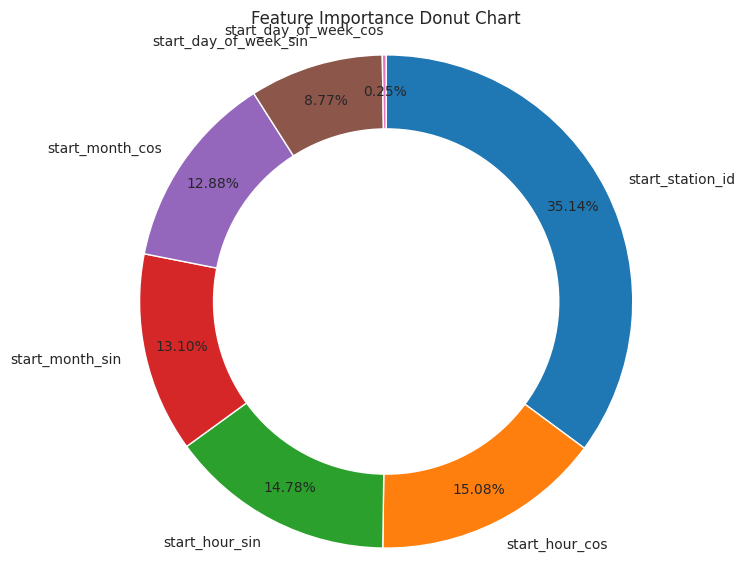

In [ ]:
# Create the donut chart using seaborn
plt.figure(figsize=(7, 7))
sns.set_style("whitegrid")

# Create the pie chart
plt.pie(
    feature_importances_df["Importance (%)"],
    labels=feature_importances_df["Feature"],
    autopct="%1.2f%%",
    startangle=90,
    counterclock=False,
    wedgeprops={"edgecolor": "white"},
    pctdistance=0.85,
)

# Create the central circle for the donut shape
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Feature Importance Donut Chart")
plt.axis('equal')
plt.show()


## XGBoost Model

In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold

# Create an XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', # Specify the objective for regression
                              n_estimators=100,            # Number of boosting rounds
                              max_depth=5,                 # Maximum depth of trees
                              learning_rate=0.1,           # Learning rate for boosting
                              random_state=42)             # Random seed for reproducibility

# Define cross-validation strategy
kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Evaluate model using cross-validation
scores = cross_val_score(xgb_model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')

# Print average cross-validation score (negative MSE)
print("Average Cross-Validation Score (XGBoost):", -scores.mean())

# Train model on full training data
xgb_model.fit(X_train, y_train)

# Make predictions on test data
y_pred_xgb = xgb_model.predict(X_test)

# Calculate Evaluation metrics)
xgb_model_mae = mean_absolute_error(y_test, y_pred_xgb)  # MAE
xgb_model_rmse = mean_squared_error(y_test, y_pred_xgb, squared=False)  # RMSE
xgb_model_r2 = r2_score(y_test, y_pred_xgb)  # R-squared

# Print the evaluation metrics
print("XGBoost Model Evaluation:")
print(f"MAE: {xgb_model_mae}")
print(f"RMSE: {xgb_model_rmse}")
print(f"R-squared: {xgb_model_r2}")

## LightGBM

In [ ]:
import lightgbm as lgb

# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)

# Define model parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train model with cross-validation
cv_results = lgb.cv(params,
                    train_data,
                    num_boost_round=1000,
                    nfold=5,
                    seed=42)

# Print best cross-validation score (RMSE)
print("Best Cross-Validation Score (LightGBM):", cv_results['valid rmse-mean'][-1])

# Train model on full training data using the best number of rounds
best_n_rounds = len(cv_results['valid rmse-mean'])  # Get the best iteration
lgb_model = lgb.train(params, train_data, num_boost_round=best_n_rounds)

# Make predictions on test data
y_pred_lgb = lgb_model.predict(X_test)

# Calculate Evaluation metrics)
lgb_model_mae  = mean_absolute_error(y_test, y_pred_lgb)  # MAE
lgb_model_rmse = mean_squared_error(y_test, y_pred_lgb, squared=False)  # RMSE
lgb_model_r2   = r2_score(y_test, y_pred_lgb)  # R-squared

# Print the evaluation metrics
print("LightGBM Model Evaluation:")
print(f"MAE: {lgb_model_mae}")
print(f"RMSE: {lgb_model_rmse}")
print(f"R-squared: {lgb_model_r2}")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: 

## Comparing all models' metrics

In [ ]:
# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Metric':                ['RMSE',         'MAE',         'R-squared'],
    'RandomForestRegressor': [rfg_model_rmse, rfg_model_mae, rfg_model_r2],
    'XGBoost':               [xgb_model_rmse, xgb_model_mae, xgb_model_r2],
    'LightGBM':              [lgb_model_rmse, lgb_model_mae, lgb_model_r2]
})

metrics_df.set_index('Metric', inplace=True)
metrics_df = metrics_df.round(2)
metrics_df

In [ ]:
# Now plot using the predictions on the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rfg, label='RFG', alpha=0.7)  # Note: Using y_test and corresponding predictions
plt.scatter(y_test, y_pred_xgb, label='LGBM', alpha=0.5)
plt.scatter(y_test, y_pred_lgb, label='XGBoost', alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal')  # Diagonal line
plt.xlabel('Actual Total Trips')
plt.ylabel('Predicted Total Trips')
plt.title('Actual vs. Predicted Total Trips')
plt.legend()
plt.show()

In [ ]:
# Get feature importances for Random Forest Regressor
feature_importances_rfg = rfg_model.feature_importances_

# Get feature importances for XGBoost
feature_importances_xgb = xgb_model.feature_importances_

# Get feature importances for LightGBM
# Use feature_importance() method with 'importance_type' argument
feature_importances_lgb = lgb_model.feature_importance(importance_type='gain')

# Create a DataFrame for better visualization
sdfm_feature_importances_df = pd.DataFrame({
    'Feature': sdfm_prediction_features,
    'Importance_RFG': np.round(feature_importances_rfg * 100, 2),
    'Importance_XGB': np.round(feature_importances_xgb * 100, 2),
    'Importance_LGB': np.round(feature_importances_lgb, 2)  # LightGBM importances might already be integers
})

# Sort by Random Forest Regressor importance in descending order (you can change this)
sdfm_feature_importances_df = sdfm_feature_importances_df.sort_values(by=['Importance_LGB'], ascending=False)

# Display the DataFrame
sdfm_feature_importances_df

## Make predictions

In [ ]:
def generate_and_predict_total_trips(num_predictions=5):
    # Generate random data for all rows at once
    predictions_data = {
        'start_station_id':      np.random.uniform(7000, 7392, size=num_predictions).astype(int),
        'start_hour_sin':        np.random.uniform(-1,   1,    size=num_predictions),
        'start_hour_cos':        np.random.uniform(-1,   1,    size=num_predictions),
        'start_day_of_week_sin': np.random.uniform(-1,   1,    size=num_predictions),
        'start_day_of_week_cos': np.random.uniform(-1,   1,    size=num_predictions),
        'start_month_sin':       np.random.uniform(-1,   1,    size=num_predictions),
        'start_month_cos':       np.random.uniform(-1,   1,    size=num_predictions),
    }

    # Create DataFrame directly
    predictions_df = pd.DataFrame(predictions_data)

    # Make predictions using the trained models
    predictions_df['rfg_predictions'] = np.round(rfg_model.predict(predictions_df[['start_station_id', 'start_hour_sin', 'start_hour_cos', 'start_day_of_week_sin', 'start_day_of_week_cos', 'start_month_sin', 'start_month_cos']]), 0)
    predictions_df['xgb_predictions'] = np.round(xgb_model.predict(predictions_df[['start_station_id', 'start_hour_sin', 'start_hour_cos', 'start_day_of_week_sin', 'start_day_of_week_cos', 'start_month_sin', 'start_month_cos']]), 0)
    predictions_df['lgb_predictions'] = np.round(lgb_model.predict(predictions_df[['start_station_id', 'start_hour_sin', 'start_hour_cos', 'start_day_of_week_sin', 'start_day_of_week_cos', 'start_month_sin', 'start_month_cos']]), 0)

    # Recover lgb_predictions_df (if needed - you can customize this part)
    # lgb_predictions_df = predictions_df[['start_station_id', 'start_hour_sin', 'start_hour_cos', 'start_day_of_week_sin', 'start_day_of_week_cos', 'start_month_sin', 'start_month_cos', 'lgb_predictions']]

    # Reverse Cyclic Encoding for making to original scale readable format
    inverse_cyclic_encoding(predictions_df)

    predictions_df = predictions_df[['start_station_id', 'start_hour', 'start_day_of_week', 'start_month', 'rfg_predictions', 'xgb_predictions', 'lgb_predictions']]

    return predictions_df



In [ ]:
# Generate and predict with 10 predictions
predictions_df = generate_and_predict_total_trips(num_predictions=10)
predictions_df

In [ ]:
predictions_df.plot(y=['rfg_predictions', 'xgb_predictions', 'lgb_predictions'], kind='bar', figsize=(10, 6))
plt.title('Model Predictions for Random Data Points')
plt.xlabel('Data Point Index')
plt.ylabel('Predicted Total Trips')
plt.xticks(rotation=0)
plt.legend(title='Models')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(predictions_df['start_hour'], predictions_df['rfg_predictions'], label='RFG', alpha=0.5)
plt.scatter(predictions_df['start_hour'], predictions_df['lgb_predictions'], label='LGBM', alpha=0.5)
plt.scatter(predictions_df['start_hour'], predictions_df['xgb_predictions'], label='XGBoost', alpha=0.5)
plt.title('Model Predictions vs. Start Hour')
plt.xlabel('Start Hour')
plt.ylabel('Predicted Total Trips')
plt.legend(title='Models')
plt.show()

# Station Clustering

In [ ]:
from sklearn.cluster import KMeans

# Prepare the data for clustering
coords = bike_stations_df[['lat', 'lon']].values

# Determine the optimal number of clusters (e.g., using elbow method)
optimal_k = 5

# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
bike_stations_df['station_cluster'] = kmeans.fit_predict(coords)

# Define a dictionary to map cluster IDs to names
cluster_names = {
    0: "Uptown",
    1: "East End",
    2: "Downtown Core",
    3: "East York",
    4: "West End"
}

# Create a new column 'cluster_name' and map cluster IDs to names
bike_stations_df['cluster_name'] = bike_stations_df['station_cluster'].map(cluster_names)

bike_stations_df.head()

In [ ]:
# Group by cluster and get the count of stations in each cluster
cluster_counts = bike_stations_df.groupby('cluster_name')['station_id'].count().reset_index(name='station_count')
cluster_counts = cluster_counts.sort_values(by='station_count', ascending=False)
cluster_counts

In [ ]:
# Define colors for each cluster
colors = ['darkred', 'darkblue', 'green', 'blue', 'purple', 'orange', 'darkgreen', 'red']
cluster_colors = {}

for i in range(0, optimal_k, 1):
    color = random.choice(colors)
    cluster_colors[cluster_counts["cluster_name"][i]] = color
    colors.remove(color)

# Get the center point for all stations (for initial map view)
all_latitudes  = bike_stations_df["lat"].to_list()
all_longitudes = bike_stations_df["lon"].to_list()
map_center     = [sum(all_latitudes) / len(all_latitudes), sum(all_longitudes) / len(all_longitudes)]

In [ ]:
# Create the map
station_cluters_map = folium.Map(location=map_center, zoom_start=12)

# Iterate through each cluster and add polygons
for cluster_name in bike_stations_df["cluster_name"].unique():
    latitudes  = bike_stations_df[bike_stations_df["cluster_name"] == cluster_name]["lat"].to_list()
    longitudes = bike_stations_df[bike_stations_df["cluster_name"] == cluster_name]["lon"].to_list()

    # Get the color for the current cluster
    color = cluster_colors.get(cluster_name, "gray")  # Default to gray if color not defined

    # Create and add the polygon for the current cluster
    folium.Polygon(
        locations=list(zip(latitudes, longitudes)),
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.3,
    ).add_to(station_cluters_map)

print(cluster_colors)
# Display the map
station_cluters_map

In [ ]:
from folium.plugins import MarkerCluster


# Create the map
bike_stations_map = folium.Map(location=map_center, zoom_start=12)

# Create separate MarkerClusters for each cluster ID
cluster_layers = {}
for cluster_name in bike_stations_df['cluster_name'].unique():
    cluster_layers[cluster_name] = MarkerCluster(
        name=f"Cluster {cluster_name}",
        overlay=True,
        control=False
    ).add_to(bike_stations_map)

# Iterate through each station and add markers to their respective clusters
for index, row in bike_stations_df.iterrows():
    cluster_name = row['cluster_name']
    cluster_color = cluster_colors.get(cluster_name, 'gray')

    # Include cluster ID in the popup content
    popup_text = f"<b>{row['name']}</b><br>Cluster: {cluster_name}"

    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=folium.Popup(popup_text, max_width=200),
        icon=folium.Icon(color=cluster_color, icon='bicycle', prefix='fa')
    ).add_to(cluster_layers[cluster_name])  # Add to the correct cluster layer

# Add LayerControl to toggle cluster visibility
folium.LayerControl().add_to(bike_stations_map)

# Display the map
bike_stations_map

# User Classification Model

## Splitting data into training and testing sets

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Select features and target variable
user_classification_features = [
    'duration_minutes',
    'start_station_id', 'end_station_id',
    'start_hour_sin', 'start_hour_cos',
    'start_day_of_week_sin', 'start_day_of_week_cos',
    'start_month_sin', 'start_month_cos'
]

target = 'user_type'

X = trips_df[user_classification_features]
y = trips_df[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression


# Initialize and train the Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)  # Increase max_iter if needed
logreg_model.fit(X_train, y_train)

# Predict on the test set
y_pred_logreg = logreg_model.predict(X_test)

# Evaluate the model
accuracy_logreg  = accuracy_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg    = recall_score(y_test, y_pred_logreg)
f1_logreg        = f1_score(y_test, y_pred_logreg)

print("Logistic Regression Model:")
print(f"  Accuracy:  {accuracy_logreg:.4f}")
print(f"  Precision: {precision_logreg:.4f}")
print(f"  Recall:    {recall_logreg:.4f}")
print(f"  F1-score:  {f1_logreg:.4f}")

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier


# Initialize and train the Random Forest Classifier model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
accuracy_rf  = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf    = recall_score(y_test, y_pred_rf)
f1_rf        = f1_score(y_test, y_pred_rf)

print("\nRandom Forest Classifier Model:")
print(f"  Accuracy:  {accuracy_rf:.4f}")
print(f"  Precision: {precision_rf:.4f}")
print(f"  Recall:    {recall_rf:.4f}")
print(f"  F1-score:  {f1_rf:.4f}")

## XGBoost Classifier

In [ ]:
from xgboost import XGBClassifier


# Initialize and train the XGBoost Classifier model
xgb_model = XGBClassifier(
    n_estimators=100,            # Number of boosting rounds (trees)
    max_depth=7,                 # Maximum depth of each tree
    learning_rate=0.1,           # Step size shrinkage used in update to prevents overfitting
    objective='binary:logistic', # Objective function for binary classification
    random_state=42              # Random seed for reproducibility
)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
accuracy_xgb  = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb    = recall_score(y_test, y_pred_xgb)
f1_xgb        = f1_score(y_test, y_pred_xgb)

print("\nXGBoost Classifier Model:")
print(f"  Accuracy:  {accuracy_xgb:.4f}")
print(f"  Precision: {precision_xgb:.4f}")
print(f"  Recall:    {recall_xgb:.4f}")
print(f"  F1-score:  {f1_xgb:.4f}")

## Comparing all 3 models

In [ ]:
# Create a DataFrame to store the metrics
user_classification_metrics_df = pd.DataFrame({
    'Metric':              ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'Logistic Regression': [accuracy_logreg, precision_logreg, recall_logreg, f1_logreg],
    'Random Forest':       [accuracy_rf, precision_rf, recall_rf, f1_rf],
    'XGBoost':             [accuracy_xgb, precision_xgb, recall_xgb, f1_xgb]
})

user_classification_metrics_df.set_index('Metric', inplace=True)
user_classification_metrics_df = user_classification_metrics_df.round(4)
user_classification_metrics_df

In [ ]:
# Get feature importances for Random Forest
feature_importances_rf = rf_model.feature_importances_

# Get feature importances for XGBoost
feature_importances_xgb = xgb_model.feature_importances_

# For Logistic Regression, we'll use the absolute values of coefficients as importance
feature_importances_logreg = np.abs(logreg_model.coef_[0])

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': user_classification_features,
    'Importance_RF':     np.round(feature_importances_rf * 100, 2),
    'Importance_XGB':    np.round(feature_importances_xgb * 100, 2),
    'Importance_LogReg': np.round(feature_importances_logreg * 100, 2)  # Using coefficients
})

# Sort by Random Forest importance in descending order
user_classification_feature_importances_df = feature_importances_df.sort_values(by=['Importance_RF'], ascending=False)

# Display the DataFrame
user_classification_feature_importances_df

## Make predictions

In [ ]:
def generate_and_predict_user_type(num_predictions=5):
    # Generate random data for features
    user_classification_predictions_data = {}

    for feature in user_classification_features:
        if feature in ['duration_minutes']:
            user_classification_predictions_data[feature] = np.random.randint(trips_df["duration_minutes"].min(), trips_df["duration_minutes"].max(), size=num_predictions)

        elif feature in ['start_station_id', 'end_station_id']:
            user_classification_predictions_data[feature] = np.random.randint(trips_df["start_station_id"].min(), trips_df["start_station_id"].max(), size=num_predictions)

        elif feature == 'start_hour_sin':
            user_classification_predictions_data[feature] = np.random.uniform(-1,   1,    size=num_predictions)
        elif feature == 'start_hour_cos':
            user_classification_predictions_data[feature] = np.random.uniform(-1,   1,    size=num_predictions)

        elif feature == 'start_day_of_week_sin':
            user_classification_predictions_data[feature] = np.random.uniform(-1,   1,    size=num_predictions)
        elif feature == 'start_day_of_week_cos':
            user_classification_predictions_data[feature] = np.random.uniform(-1,   1,    size=num_predictions)

        elif feature == 'start_month_sin':
            user_classification_predictions_data[feature] = np.random.uniform(-1,   1,    size=num_predictions)
        elif feature == 'start_month_cos':
            user_classification_predictions_data[feature] = np.random.uniform(-1,   1,    size=num_predictions)

    user_classification_predictions_df = pd.DataFrame(user_classification_predictions_data)

    # Create DataFrame
    user_classification_predictions_df = pd.DataFrame(user_classification_predictions_data)

    # Reverse Cyclic Encoding for making to original scale readable format
    inverse_cyclic_encoding(user_classification_predictions_df)

    # Predict user type using the trained models
    user_classification_predictions_df['logreg_predictions'] = logreg_model.predict(user_classification_predictions_df[user_classification_features])
    user_classification_predictions_df['rf_predictions']     = rf_model.predict(user_classification_predictions_df[user_classification_features])
    user_classification_predictions_df['xgb_predictions']    = xgb_model.predict(user_classification_predictions_df[user_classification_features])

    user_classification_predictions_df = user_classification_predictions_df[['duration_minutes', 'start_station_id', 'end_station_id', 'start_hour', 'start_day_of_week', 'start_month', 'logreg_predictions', 'rf_predictions', 'xgb_predictions']]
    return user_classification_predictions_df

user_classification_predictions_df = generate_and_predict_user_type(num_predictions=20)
user_classification_predictions_df

# Feature Scaling

Only Continous variables need scaling,
not Categorical, Dummy or Binary variables.

In [ ]:
def minmax_scale(data):
    """Scales data to the range [0, 1] using MinMax scaling."""
    min_val = data.min()
    max_val = data.max()
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data


def inverse_minmax_scale(scaled_data, original_min, original_max):
    """Inverse transforms scaled data back to the original scale."""
    original_data = scaled_data * (original_max - original_min) + original_min
    return original_data


def do_scaling():
    # Store original min and max
    total_trips_min = sdfm_df['total_trips'].min()
    total_trips_max = sdfm_df['total_trips'].max()

    # Select columns for scaling
    numerical_columns = ['start_hour_sin', 'start_hour_cos', 'start_day_of_week_sin', 'start_day_of_week_cos', 'start_month_sin', 'start_month_cos']

    # Apply MinMax scaling to each selected column
    for column in numerical_columns:
        sdfm_df[column] = minmax_scale(sdfm_df[column])
